In [1]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
import h5py
import pickle
import requests
import os.path
from astropy.cosmology import LambdaCDM
from unyt import Myr, K
from synthesizer.particle import Stars, Gas, Galaxy
from synthesizer.grid import Grid
from synthesizer.emission_models import IncidentEmission, PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody

Illustris API key

In [2]:
api_key = "c37483fea84b70f4ad9f777c38357ea0"

### Get properties of the simulation

In [3]:
baseUrl = 'http://www.tng-project.org/api/TNG50-1/'
headers = {"api-key":api_key}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

simulation = get(baseUrl)

HTTPError: 503 Server Error: Service Unavailable for url: https://www.tng-project.org/api/TNG50-1/

In [ ]:
for k, v in simulation.items():
    print(f'{k}: {v}')


name: TNG50-1
description: Main high-resolution IllustrisTNG50 run including the full TNG physics model.
name_alt: L35n2160TNG
boxsize: 35000.0
z_start: 127.0
z_final: 0.0
cosmology: Planck2015
omega_0: 0.3089
omega_L: 0.6911
omega_B: 0.0486
hubble: 0.6774
physics_model: Fiducial TNG Model
has_cooling: True
has_starformation: True
has_winds: True
has_blackholes: True
mass_gas: 5.73879e-06
mass_dm: 3.07367708626464e-05
softening_dm_comoving: 0.39
softening_stars_comoving: 0.39
softening_blackholes_comoving: 0.39
softening_gas_comoving: 0.39
softening_dm_max_phys: 0.195
softening_stars_max_phys: 0.195
softening_blackholes_max_phys: 0.39
softening_gas_max_phys: 0.195
softening_gas_factor: 2.5
softening_gas_comoving_min: 0.05
num_dm: 10077696000
num_tr_mc: 10077696000
num_tr_vel: 0
longids: True
is_uniform: True
is_zoom: False
is_subbox: False
num_files_snapshot: 680
num_files_groupcat: 680
num_files_rockstar: 0
num_files_lhalotree: 200
num_files_sublink: 11
num_files_ctrees: 0
filesize_lh

### Define cosmology

In [ ]:
h = simulation['hubble']
Om0 = simulation['omega_0']
Ode0 = simulation['omega_L']
H0 = h * 100 
Ob0 = simulation['omega_B']

cosmo = LambdaCDM(Om0=Om0, Ode0=Ode0, H0=H0, Ob0=Ob0)

In [ ]:
# create a dictionary of snapshots and redshifts (useful later)
snapshots = get(simulation['snapshots'])
snapshot_redshifts = {snapshot['number']: snapshot['redshift'] for snapshot in snapshots}
print(snapshot_redshifts)

{0: 20.0464909888075, 1: 14.9891732400424, 2: 11.9802133153003, 3: 10.9756432941379, 4: 9.99659046618633, 5: 9.38877127194055, 6: 9.00233985416247, 7: 8.44947629436874, 8: 8.01217294886593, 9: 7.5951071498716, 10: 7.23627606616736, 11: 7.00541704554453, 12: 6.4915977456675, 13: 6.0107573988449, 14: 5.84661374788187, 15: 5.5297658079491, 16: 5.22758097312734, 17: 4.99593346816462, 18: 4.66451770247093, 19: 4.42803373660555, 20: 4.17683491472647, 21: 4.00794511146527, 22: 3.70877426464224, 23: 3.49086136926065, 24: 3.28303305795652, 25: 3.00813107163038, 26: 2.89578500572743, 27: 2.73314261731872, 28: 2.57729027160189, 29: 2.44422570455415, 30: 2.31611074395689, 31: 2.2079254723837, 32: 2.10326965259577, 33: 2.00202813925285, 34: 1.90408954353277, 35: 1.82268925262035, 36: 1.74357057433086, 37: 1.66666955611447, 38: 1.60423452207311, 39: 1.53123902915761, 40: 1.49551216649556, 41: 1.41409822037252, 42: 1.357576667403, 43: 1.30237845990597, 44: 1.24847261424514, 45: 1.206258080781, 46: 1.

### Define choice of galaxy/redshift

In [ ]:
id = '145492'
redshift = 2.0

### Download data

In [ ]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open('data/'+filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r


# the quantities that we want to grab: the coordinates, metallicity, age, and initial mass of all the star particles
params = {
    'stars':'Coordinates,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass',
    'gas': 'Coordinates,GFM_Metallicity,SubfindHsml,Masses'
    }

# the data url for the object of interest
url = f"{baseUrl}/snapshots/z={str(redshift)}/subhalos/{str(id)}"

# Download the subhalo properties for the specific galaxy and save them as pickle file
subhalo_properties_filename = f'data/subhalo_properties_{id}.pck'
if not os.path.isfile(subhalo_properties_filename):
    subhalo_properties = get(url) # get json response of subhalo properties
    pickle.dump(subhalo_properties, open(subhalo_properties_filename,'wb'))

# Download the HDF5 cutout for the galaxy if it hasn't already been downloaded
cutout_filename = f'data/cutout_{id}.hdf5'
if not os.path.isfile(cutout_filename):
    get(url + "/cutout.hdf5", params) # get and save HDF5 cutout file

Print sub-halo properties and determine the exact snapshot redshift

In [ ]:
subhalo_properties = pickle.load(open(f'data/subhalo_properties_{id}.pck','rb'))
for k,v in subhalo_properties.items():
    print(f'{k}: {v}')

snapshot_redshift = snapshot_redshifts[subhalo_properties['snap']]
print(f'snapshot redshift: {snapshot_redshift}')

snap: 33
id: 145492
bhmdot: 0.00214158
cm_x: 2631.63
cm_y: 22423.6
cm_z: 32813.0
gasmetallicity: 0.0234775
gasmetallicityhalfrad: 0.0332981
gasmetallicitymaxrad: 0.0139534
gasmetallicitysfr: 0.0156152
gasmetallicitysfrweighted: 0.0216725
pos_x: 2614.18
pos_y: 22429.6
pos_z: 32811.7
halfmassrad: 71.0307
halfmassrad_gas: 67.2129
halfmassrad_dm: 75.0715
halfmassrad_stars: 7.5072
halfmassrad_bhs: 0.0
len: 2303786
len_gas: 793943
len_dm: 1201183
len_stars: 308659
len_bhs: 1
mass: 43.4305
mass_gas: 5.0807
mass_dm: 36.9205
mass_stars: 1.42703
mass_bhs: 0.002327
massinhalfrad: 2.0413
massinhalfrad_gas: 0.196656
massinhalfrad_dm: 1.12881
massinhalfrad_stars: 0.713511
massinhalfrad_bhs: 0.002327
massinmaxrad: 12.493
massinmaxrad_gas: 1.64067
massinmaxrad_dm: 9.48976
massinmaxrad_stars: 1.36023
massinmaxrad_bhs: 0.002327
massinrad: 4.61426
massinrad_gas: 0.622574
massinrad_dm: 2.90797
massinrad_stars: 1.08139
massinrad_bhs: 0.002327
sfr: 15.455
sfrinhalfrad: 4.07666
sfrinmaxrad: 15.043
sfrinrad: 

Explore HDF5 file

In [ ]:
with h5py.File(cutout_filename) as f:
    f.visit(print)

Header
PartType0
PartType0/Coordinates
PartType0/GFM_Metallicity
PartType0/Masses
PartType0/SubfindHsml
PartType4
PartType4/Coordinates
PartType4/GFM_InitialMass
PartType4/GFM_Metallicity
PartType4/GFM_StellarFormationTime


### Creating a Galaxy object

After downloading the data we need to create a synthesizer galaxy object.


In [ ]:

with h5py.File(cutout_filename) as f:

    # GFM_StellarFormationTime is the scale factor when the  
    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    # only select star particles that make sense
    s = formation_redshift >= snapshot_redshift
    formation_redshift = formation_redshift[s]

    # calculate the ages of star particle and record as unyt quantity
    ages = (cosmo.age(z=snapshot_redshift)-cosmo.age(formation_redshift)).to('Myr').value * Myr

    # convert units of initial masses
    initial_masses = f['PartType4']['GFM_InitialMass'][s] * 1E10 / h

    # define the coorindates of the star particles 
    x = f['PartType4']['Coordinates'][s,0] 
    y = f['PartType4']['Coordinates'][s,1] 
    z = f['PartType4']['Coordinates'][s,2] 

    # convert coordinates to physical and change the units
    coordinates = np.array([x,y,z]).T / (1+snapshot_redshift) / h / 1000

    # create a stars object
    stars = Stars(
        ages=ages,
        initial_masses=initial_masses,
        metallicities=f['PartType4']['GFM_Metallicity'][s],
        coordinates=coordinates,
        )
    
    # define the coorindates of the gas particles 
    x = f['PartType0']['Coordinates'][:,0] 
    y = f['PartType0']['Coordinates'][:,1] 
    z = f['PartType0']['Coordinates'][:,2] 

    # convert coordinates to physical and change the units
    coordinates = np.array([x,y,z]).T  / (1 + snapshot_redshift) / h / 1000


    # create a gas object
    gas = Gas(
        masses=f['PartType0']['Masses'][:] * 1E10 / h,
        metallicities=f['PartType0']['GFM_Metallicity'][:],
        smoothing_lengths=f['PartType0']['SubfindHsml'][:] / (1 + snapshot_redshift) / h / 1000,
        coordinates=coordinates,
        )


centre = np.array([subhalo_properties['pos_x'],
                   subhalo_properties['pos_y'],
                   subhalo_properties['pos_z'],
                   ]) / (1 + snapshot_redshift) / h / 1000,

# initialise the galaxy object
galaxy = Galaxy(stars=stars, gas=gas, centre=centre)

/Users/sw376/Dropbox/Research/projects/synthesizer-lines/venv/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16163/4068504354.py:43: RuntimeWarning: Neither dust mass nor dust to metal ratio provided. Assuming dust to metal ratio = 0.3
  gas = Gas(
/Users/sw376/Dropbox/Research/projects/synthesizer/src/synthesizer/particle/galaxy.py:113: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/sw376/Dropbox/Research/projects/synthesizer/src/synthesizer/particle/galaxy.py:116: RuntimeWarning: Star forming gas particle mask not provided, setting sf_gas_mass and sf_gas_metallicity to `None`
  self.calculate_integrated_gas_properties()


### Show SFZH

/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_16163/314651429.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


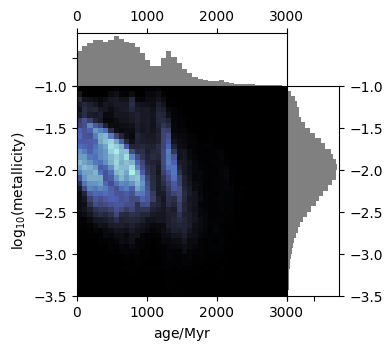

In [ ]:
metallicities = galaxy.stars.metallicities
ages = galaxy.stars.ages
initial_masses = galaxy.stars._initial_masses

cmap = cmr.sapphire
age_range = [0., 3000.]
log10metallicity_range = [-3.5, -1.]
nbins = 40

fig = plt.figure(figsize=(3.5, 3.5))

bottom = 0.15
height = 0.6
hsize = 0.15
left = 0.15
width = 0.6

ax = fig.add_axes((left, bottom, width, height))
axx = fig.add_axes((left, bottom+height, width, hsize))
axy = fig.add_axes((left+width, bottom, hsize, height))

hist, xedges, yedges = np.histogram2d(ages.to('Myr').value, 
                                      np.log10(metallicities), 
                                      bins=[nbins,nbins], 
                                      range=[age_range, log10metallicity_range],
                                      weights=initial_masses)

axx.hist(ages.to('Myr').value, bins=nbins, range=age_range, weights=initial_masses,color='0.5')
axy.hist(np.log10(metallicities), bins=nbins, range=log10metallicity_range, weights=initial_masses, orientation='horizontal',color='0.5')

ax.imshow(hist.T, 
           origin='lower', 
           interpolation='nearest', 
           extent=[*age_range, *log10metallicity_range],
           aspect='auto',
           cmap=cmap)


axx.set_xlim(age_range)
axx.set_yticklabels([])
axx.xaxis.set_ticks_position('top')

axy.set_ylim(log10metallicity_range)
axy.set_xticklabels([])
axy.yaxis.set_ticks_position('right')

ax.set_xlabel(r'$\rm age/Myr$')
ax.set_ylabel(r'$\rm log_{10}(metallicity)$')

fig.savefig('figs/tng-age_metallicity.pdf')
fig.show()

### LOS dust

Calculate the line-of-sight surface density of dust to each star particle in the galaxy.

This should take up-to 20 minutes.



In [ ]:
from synthesizer.kernel_functions import Kernel

kappa = 0.3
kernel = Kernel()
galaxy.calculate_los_tau_v(kappa=kappa, kernel=kernel.get_kernel(), force_loop=True)

array([3.97283344e-01, 4.00301560e-01, 4.02388592e-01, ...,
       5.78807113e-07, 0.00000000e+00, 1.49133546e-04])

Plot the distribution of $\tau_V$ values:

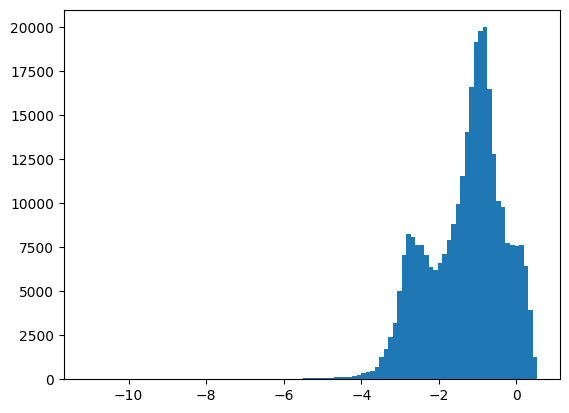

In [ ]:
tauv = galaxy.stars.tau_v
tauv = tauv[tauv>0.0]

plt.hist(np.log10(tauv), bins=100)
plt.show()

### Save

We now use pickle to save the Galaxy object for use in other notebooks.

In [ ]:
import pickle

pickle.dump(galaxy, open(f'data/galaxy_{id}.pck','wb'))